In [1]:
# Celda 1: Carga y Limpieza de Datos (Reestructurada)

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import CountVectorizer
from bertopic import BERTopic
from bertopic.representation import KeyBERTInspired
import os
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
import re
import random
import sqlite3

# --- Descarga de recursos de NLTK (si es necesario) ---
try:
    nltk.data.find('corpora/stopwords')
except nltk.downloader.DownloadError:
    nltk.download('stopwords', quiet=True)
try:
    nltk.data.find('tokenizers/punkt')
except nltk.downloader.DownloadError:
    nltk.download('punkt', quiet=True)

# ==============================================================================
# --- HIPERPARÁMETROS Y CONSTANTES ---
# ==============================================================================
MODEL_PATH = "aging_topics.bertopic"
DB_NAME = "fightaging_articles.db"

# --- Control de Muestreo ---
# True: Usa solo una porción de los datos para pruebas rápidas.
# False: Usa el conjunto de datos completo para el análisis final.
use_sample = False
SAMPLE_DAYS = 730  # 2 años. Solo se usa si use_sample = True.

# ==============================================================================
# --- FUNCIONES AUXILIARES ---
# ==============================================================================
def load_data_from_db(db_name="fightaging_articles.db"):
    """Carga todos los artículos de la base de datos SQLite a un DataFrame."""
    try:
        conn = sqlite3.connect(db_name)
        df = pd.read_sql_query("SELECT * FROM articles", conn)
        conn.close()
        df['publish_date'] = pd.to_datetime(df['publish_date'])
        print(f"✅ Se cargaron exitosamente {len(df)} artículos desde '{db_name}'.")
        return df
    except Exception as e:
        print(f"❌ No se pudieron cargar los datos de la base de datos. Error: {e}")
        return pd.DataFrame()

def simple_clean_text(text):
    """Limpia el texto: minúsculas, quita puntuación/números, etc."""
    if pd.isna(text):
        return ""
    text = str(text).lower()
    text = re.sub(r'[^a-z\s]', '', text)  # Solo deja letras y espacios
    tokens = word_tokenize(text)
    filtered_tokens = [word for word in tokens if len(word) > 2]
    return " ".join(filtered_tokens)

# ==============================================================================
# --- LÓGICA PRINCIPAL DE CARGA Y PREPROCESAMIENTO ---
# ==============================================================================

# Carga los datos solo si no están ya en memoria
if 'articles_df' not in locals() or articles_df.empty:
    print("DataFrame no encontrado en memoria, cargando desde la base de datos...")
    articles_df = load_data_from_db(DB_NAME)
else:
    print(f"Usando el DataFrame 'articles_df' preexistente con {len(articles_df)} filas.")

# Procede solo si el DataFrame tiene datos
if not articles_df.empty:
    try:
        # 1. Preprocesamiento del texto y fechas
        print("Iniciando preprocesamiento de datos...")
        articles_df['full_text'] = articles_df['title'].astype(str) + ' ' + articles_df['body'].astype(str)
        articles_df['cleaned_text'] = articles_df['full_text'].apply(simple_clean_text)
        articles_df.dropna(subset=['cleaned_text', 'publish_date'], inplace=True)
        articles_df.sort_values(by='publish_date', inplace=True, ascending=True)
        
        # 2. Selección de datos (Muestra vs. Completo) controlada por 'use_sample'
        if use_sample:
            print(f"\n--- 🧪 MODO DE MUESTRA ACTIVADO (use_sample=True) ---")
            print(f"Seleccionando los primeros {SAMPLE_DAYS} días de datos.")
            start_date = articles_df['publish_date'].min()
            end_date = start_date + pd.Timedelta(days=SAMPLE_DAYS)
            
            # Filtra el DataFrame para obtener la muestra
            df_final = articles_df[articles_df['publish_date'] <= end_date].copy()
            
            print(f"Rango de fechas de la muestra: {df_final['publish_date'].min().date()} a {df_final['publish_date'].max().date()}")
        else:
            print(f"\n--- 🚀 MODO DE DATASET COMPLETO (use_sample=False) ---")
            df_final = articles_df.copy()
            print(f"Rango de fechas completo: {df_final['publish_date'].min().date()} a {df_final['publish_date'].max().date()}")

        # 3. Preparación de listas para el modelo
        documents = df_final['cleaned_text'].tolist()
        timestamps = df_final['publish_date'].tolist()

        if not documents:
            print("❌ ERROR: La lista de documentos está vacía después del filtrado.")
        else:
            print(f"\n✅ Datos listos para el modelado: {len(documents)} documentos.")

    except Exception as e:
        print(f"❌ Ocurrió un error durante el preprocesamiento: {e}")
        documents, timestamps = [], []
else:
    print("El DataFrame está vacío. No se puede continuar con el procesamiento.")
    documents, timestamps = [], []

/media/flan/Bodega4T1/CodeProjects/AgingLiterature/.venv/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


DataFrame no encontrado en memoria, cargando desde la base de datos...
✅ Se cargaron exitosamente 18753 artículos desde 'fightaging_articles.db'.
Iniciando preprocesamiento de datos...

--- 🚀 MODO DE DATASET COMPLETO (use_sample=False) ---
Rango de fechas completo: 2002-11-01 a 2025-09-19

✅ Datos listos para el modelado: 18753 documentos.


In [2]:
# Celda 2: Entrenamiento y Asignación de Tópicos

from sentence_transformers import SentenceTransformer

# Solo ejecutar si la celda 1 cargó datos correctamente
if 'documents' in locals() and documents:
    # --- a. Configuración y Rutas ---
    if use_sample:
        MODEL_PATH = "aging_topics_sample.bertopic"
        print(f"--- 🧪 MODO MUESTRA: Se usará el modelo en '{MODEL_PATH}' ---")
    else:
        MODEL_PATH = "aging_topics_full.bertopic"
        print(f"--- 🚀 MODO COMPLETO: Se usará el modelo en '{MODEL_PATH}' ---")

    # --- b. Pre-cálculo de Embeddings ---
    print("\nGenerando embeddings para los documentos...")
    embedding_model = SentenceTransformer("all-MiniLM-L6-v2")
    embeddings = embedding_model.encode(documents, show_progress_bar=True)
    print(f"✅ Embeddings generados con dimensiones: {embeddings.shape}")

    # --- c. Cargar o Entrenar el Modelo ---
    if os.path.exists(MODEL_PATH):
        print(f"\nCargando modelo existente desde '{MODEL_PATH}'...")
        topic_model = BERTopic.load(MODEL_PATH)
    else:
        print("\nEntrenando un nuevo modelo BERTopic...")
        vectorizer_model = CountVectorizer(ngram_range=(1, 3), stop_words="english")
        keybert_representation = KeyBERTInspired()
        representation_model = {"KeyBERT_Frases": keybert_representation}
        
        topic_model = BERTopic(
            embedding_model=embedding_model,
            language="english",
            verbose=True,
            vectorizer_model=vectorizer_model,
            representation_model=representation_model,
        )
        topic_model.fit(documents, embeddings) # Usamos fit() ya que transformaremos después
        topic_model.save(MODEL_PATH)
        print(f"\n✅ ¡Modelo nuevo entrenado y guardado en '{MODEL_PATH}'!")

    # --- d. Asignación de Tópicos (¡Paso Clave para la Celda 4!) ---
    # Asignamos los tópicos a los documentos usando los embeddings pre-calculados.
    # Esta variable 'topics' será usada en las celdas siguientes.
    print("\nAsignando tópicos a los documentos actuales (esto será rápido)...")
    topics, _ = topic_model.transform(documents, embeddings)
    print("✅ Tópicos asignados.")

else:
    print("❌ No hay datos para entrenar el modelo. Ejecuta la Celda 1 primero.")

--- 🚀 MODO COMPLETO: Se usará el modelo en 'aging_topics_full.bertopic' ---

Generando embeddings para los documentos...


Batches: 100%|██████████| 587/587 [00:37<00:00, 15.59it/s]


✅ Embeddings generados con dimensiones: (18753, 384)

Cargando modelo existente desde 'aging_topics_full.bertopic'...

Asignando tópicos a los documentos actuales (esto será rápido)...
✅ Tópicos asignados.


In [3]:
# # Celda 3: Análisis y Visualizaciones

# if 'topic_model' in locals() and 'documents' in locals() and 'embeddings' in locals():
#     # ==============================================================================
#     # --- a. Sincronización de Tópicos (¡PASO CLAVE!) ---
#     # ==============================================================================
#     # Siempre asignamos los tópicos a los documentos ANTES de cualquier análisis.
#     # Esto asegura que la variable 'topics' esté 100% sincronizada con 'topic_model'.
#     print("Sincronizando tópicos con el modelo actual (esto es rápido)...")
#     topics, _ = topic_model.transform(documents, embeddings)
#     print("✅ Sincronización completada.")

#     # ==============================================================================
#     # --- b. Gráfico de Barras de los Tópicos Principales ---
#     # ==============================================================================
#     print("\n--- Gráfico de Frecuencia de Tópicos ---")
#     # Muestra los 15 tópicos más frecuentes (excluyendo el tópico -1 de "outliers")
#     display(topic_model.visualize_barchart(top_n_topics=15))
    
#     # ==============================================================================
#     # --- c. Evolución de Tópicos a lo Largo del Tiempo ---
#     # ==============================================================================
#     print("\n--- Gráfico de Evolución Temporal ---")
#     topics_over_time = topic_model.topics_over_time(
#         docs=documents, 
#         timestamps=timestamps, 
#         topics=topics,  # Ahora esta variable está garantizada de ser correcta
#         nr_bins=20
#     )
#     # Visualiza los 8 tópicos más importantes a lo largo del tiempo
#     display(topic_model.visualize_topics_over_time(topics_over_time, top_n_topics=8))

#     # ==============================================================================
#     # --- d. Análisis Detallado de un Tópico Específico por ID ---
#     # ==============================================================================
#     topic_info_df = topic_model.get_topic_info()
    
#     if len(topic_info_df) > 1:
#         # Cambia este ID para explorar cualquier tópico que te interese de la tabla anterior
#         topic_id_to_inspect = topic_info_df.iloc[1]['Topic'] # Inspecciona el más frecuente
        
#         print(f"\n--- 🔎 Análisis Detallado del Tópico ID: {topic_id_to_inspect} ---")
#         topic_name = topic_info_df.loc[topic_info_df['Topic'] == topic_id_to_inspect, 'Name'].iloc[0]
#         print(f"Nombre: {topic_name}")
        
#         print("\nPalabras Clave:")
#         print([word for word, score in topic_model.get_topic(topic_id_to_inspect)])
        
#         print("\nDocumentos más representativos de este tópico:")
#         representative_docs = topic_model.get_representative_docs(topic_id_to_inspect)
#         for doc in representative_docs:
#             print(f"- {doc[:150]}...") # Imprime un fragmento
#     else:
#         print("\n[ADVERTENCIA]: No se encontraron tópicos para analizar (solo outliers).")

# else:
#     print("❌ El modelo, los documentos o los embeddings no están disponibles. Ejecuta las celdas anteriores primero.")

In [ ]:
# Celda 3: Sincronización y Carga/Cálculo de Resultados

import numpy as np
import pandas as pd
import os

if 'topic_model' in locals() and 'documents' in locals() and 'embeddings' in locals():
    # --- a. Definir Rutas de Archivos ---
    RESULTS_DIR = "inference_results"
    os.makedirs(RESULTS_DIR, exist_ok=True) # Crea el directorio si no existe

    # Rutas dinámicas basadas en si usamos la muestra o el dataset completo
    if use_sample:
        topics_path = os.path.join(RESULTS_DIR, "topics_sample.npy")
        time_path = os.path.join(RESULTS_DIR, "topics_over_time_sample.csv")
    else:
        topics_path = os.path.join(RESULTS_DIR, "topics_full.npy")
        time_path = os.path.join(RESULTS_DIR, "topics_over_time_full.csv")

    # --- b. Lógica de Carga o Cálculo ---
    # Revisa si los archivos de resultados ya existen
    if os.path.exists(topics_path) and os.path.exists(time_path):
        # --- VÍA RÁPIDA: Cargar desde disco ---
        print(f"✅ Cargando resultados pre-calculados desde '{RESULTS_DIR}'...")
        
        topics = np.load(topics_path)
        topics_over_time = pd.read_csv(time_path, parse_dates=['Timestamp'])
        
        print("¡Resultados cargados exitosamente!")

    else:
        # --- VÍA LENTA: Calcular y luego Guardar ---
        print("❌ No se encontraron resultados pre-calculados. Calculando ahora (esto puede tardar)...")
        
        # 1. Sincronizar tópicos (usa la GPU)
        print("Asignando tópicos a documentos...")
        topics, _ = topic_model.transform(documents, embeddings)
        
        # 2. Calcular evolución temporal
        print("Calculando evolución de tópicos a lo largo del tiempo...")
        topics_over_time = topic_model.topics_over_time(
            docs=documents, 
            timestamps=timestamps, 
            topics=topics,
            nr_bins=20
        )
        print("✅ Cálculos completados.")
        
        # 3. Guardar los nuevos resultados para la próxima vez
        print(f"Guardando nuevos resultados en '{RESULTS_DIR}'...")
        np.save(topics_path, topics)
        topics_over_time.to_csv(time_path, index=False)
        print("✅ ¡Resultados guardados para futuras sesiones!")

    # Al final de esta celda, 'topics' y 'topics_over_time' siempre estarán disponibles
    print("\n--- Resultados listos para el análisis y la visualización. ---")

else:
    print("❌ El modelo, los documentos o los embeddings no están disponibles. Ejecuta las celdas anteriores primero.")

❌ No se encontraron resultados pre-calculados. Calculando ahora (esto puede tardar)...
Asignando tópicos a documentos...
Calculando evolución de tópicos a lo largo del tiempo...


2it [03:03, 106.18s/it]

In [ ]:
# Celda 4: Gráfico de Frecuencia de Tópicos

if 'topic_model' in locals():
    # --- b. Gráfico de Barras de los Tópicos Principales ---
    print("\n--- Gráfico de Frecuencia de Tópicos ---")
    # Muestra los 15 tópicos más frecuentes (excluyendo el tópico -1 de "outliers")
    display(topic_model.visualize_barchart(top_n_topics=15))
else:
    print("❌ El modelo no está disponible. Ejecuta las celdas anteriores primero.")

In [ ]:
# Celda 5: Gráfico de Evolución Temporal

if 'topic_model' in locals() and 'topics' in locals():
    # --- c. Evolución de Tópicos a lo Largo del Tiempo ---
    print("\n--- Gráfico de Evolución Temporal ---")
    
    # Este cálculo es rápido porque usa la variable 'topics' ya sincronizada.
    topics_over_time = topic_model.topics_over_time(
        docs=documents, 
        timestamps=timestamps, 
        topics=topics,
        nr_bins=20
    )
    
    # Visualiza los 8 tópicos más importantes a lo largo del tiempo
    display(topic_model.visualize_topics_over_time(topics_over_time, top_n_topics=8))

else:
    print("❌ El modelo o la variable 'topics' no están disponibles. Ejecuta las celdas anteriores primero.")

In [ ]:
# Celda 6: Análisis Detallado de un Tópico Específico

if 'topic_model' in locals():
    # --- d. Análisis Detallado de un Tópico Específico por ID ---
    topic_info_df = topic_model.get_topic_info()
    
    if len(topic_info_df) > 1:
        # --- PARÁMETRO INTERACTIVO ---
        # Cambia este ID para explorar cualquier tópico que te interese.
        # Por defecto, inspecciona el tópico más frecuente.
        topic_id_to_inspect = topic_info_df.iloc[1]['Topic']
        # -----------------------------
        
        print(f"\n--- 🔎 Análisis Detallado del Tópico ID: {topic_id_to_inspect} ---")
        topic_name = topic_info_df.loc[topic_info_df['Topic'] == topic_id_to_inspect, 'Name'].iloc[0]
        print(f"Nombre: {topic_name}")
        
        print("\nPalabras Clave:")
        print([word for word, score in topic_model.get_topic(topic_id_to_inspect)])
        
        print("\nDocumentos más representativos de este tópico:")
        representative_docs = topic_model.get_representative_docs(topic_id_to_inspect)
        for doc in representative_docs:
            print(f"- {doc[:150]}...")
    else:
        print("\n[ADVERTENCIA]: No se encontraron tópicos para analizar (solo outliers).")

else:
    print("❌ El modelo no está disponible. Ejecuta las celdas anteriores primero.")

--- Tabla de N-Gramas Relevantes por Tópico y Año ---


,Year,Name,N-Grams_Text,Frequency
13,2002,2_restriction_calorie_calorie restriction_diet,calorie restriction,10
11,2002,0_stem_cell_stem cell_research,theraputic cloning,6
3,2002,2_restriction_calorie_calorie restriction_diet,calorie restriction,4
12,2002,1_aging_life_research_extension,natural death,4
1,2002,0_stem_cell_stem cell_research,"barriers facing stem, facing stem cell, barrie...",3
8,2002,9_newsletter_longevity meme_meme_rss,"link httpwwwlongevitymemeorg, new look, longev...",2
16,2002,5_cryonics_alcor_suspension_life,alcor newsletter,2
5,2002,4_cancer_nanotechnology_nanomedicine_medical,"examines high cost, conference examines high, ...",1
7,2002,8_telomeres_aging_telomere_link,"lengthening telomeres, telomeres play importan...",1
9,2002,11_hormone_growth_growth hormone_hgh,"growth hormones, hormones infoaging carrying, ...",1



--- Gráfico de Evolución de N-Gramas para el Tópico: '0_stem_cell_stem cell_research' ---


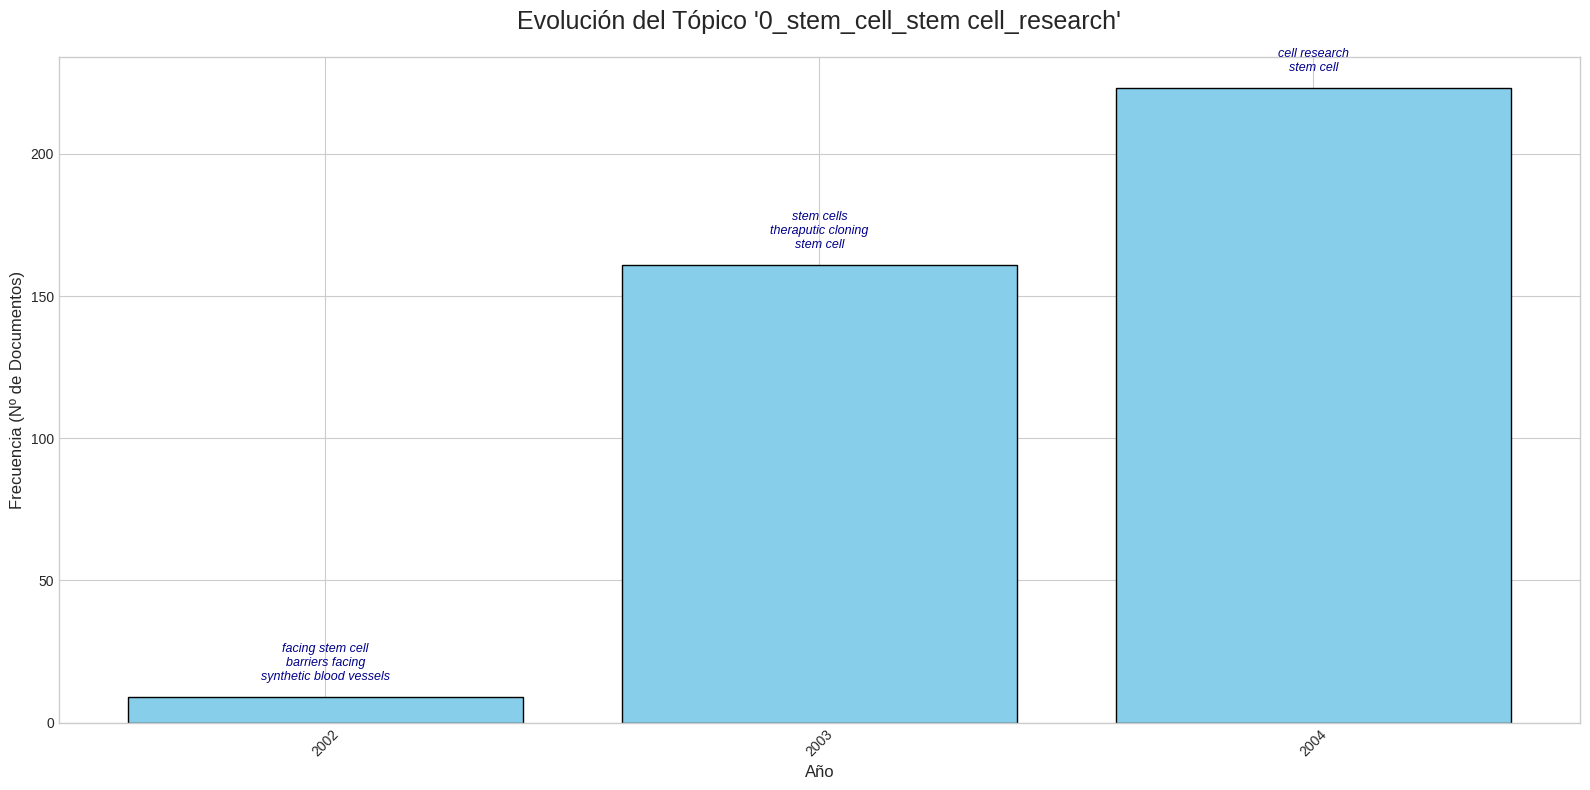

In [ ]:
# Celda 7: Visualización de N-Gramas a través del Tiempo

# Asegurarnos de que las variables necesarias de las celdas anteriores existen
if 'topic_model' in locals() and 'topics_over_time' in locals() and not topics_over_time.empty:

    # ==============================================================================
    # --- 1. Preparación de la Tabla de N-Gramas por Tópico y Año 📊 ---
    # ==============================================================================
    print("--- Tabla de N-Gramas Relevantes por Tópico y Año ---")
    
    df_ngrams = topics_over_time.copy()
    df_ngrams['Year'] = df_ngrams['Timestamp'].dt.year

    def filter_ngrams(words_string):
        """Filtra una cadena de palabras para devolver solo los bigramas y trigramas."""
        if not isinstance(words_string, str):
            return []
        word_list = words_string.split(', ')
        ngrams = [word.strip() for word in word_list if ' ' in word.strip()]
        return ngrams

    # Se aplican las funciones para extraer y formatear los n-gramas
    df_ngrams['N-Grams_List'] = df_ngrams['Words'].apply(filter_ngrams)
    df_ngrams['N-Grams_Text'] = df_ngrams['N-Grams_List'].apply(lambda x: ', '.join(x))

    # Se enriquece la tabla con los nombres de los tópicos
    topic_info = topic_model.get_topic_info()[['Topic', 'Name']]
    df_ngrams = pd.merge(df_ngrams, topic_info, on='Topic')
    
    # Se filtran las filas que no son útiles para la visualización
    df_ngrams_filtered = df_ngrams[(df_ngrams['N-Grams_Text'] != '') & (df_ngrams['Topic'] != -1)]
    
    final_table = df_ngrams_filtered[['Year', 'Name', 'N-Grams_Text', 'Frequency']]
    final_table = final_table.sort_values(by=['Year', 'Frequency'], ascending=[True, False])

    # Se muestra la tabla resultante
    display(final_table.head(20))

    # ==============================================================================
    # --- 2. Gráfico de Evolución para un Tópico Específico 📈 ---
    # ==============================================================================
    
    # --- PARÁMETRO INTERACTIVO ---
    # Cambia este ID para visualizar la evolución de cualquier otro tópico.
    # Por defecto, visualiza el tópico más frecuente.
    if len(topic_info) > 1:
        topic_id_to_visualize = topic_info.iloc[1]['Topic']
    else:
        topic_id_to_visualize = -1 # Valor seguro si no hay tópicos
    
    # -----------------------------
    
    if topic_id_to_visualize != -1:
        topic_name = topic_info.loc[topic_info['Topic'] == topic_id_to_visualize, 'Name'].iloc[0]

        print(f"\n--- Gráfico de Evolución de N-Gramas para el Tópico: '{topic_name}' (ID: {topic_id_to_visualize}) ---")

        df_topic_evo = df_ngrams[df_ngrams['Topic'] == topic_id_to_visualize].copy()
        
        # Se verifica que haya datos para graficar
        if not df_topic_evo.empty and df_topic_evo['N-Grams_List'].explode().notna().any():
            # Se agrupan los datos por año para la visualización
            df_plot_data = df_topic_evo.groupby('Year').agg(
                Total_Frequency=('Frequency', 'sum'),
                All_N_Grams=('N-Grams_List', lambda x: list(set([item for sublist in x for item in sublist])))
            ).reset_index()
            
            # Se seleccionan los 3 n-gramas principales para mostrar en el gráfico
            df_plot_data['Top_N-Grams'] = df_plot_data['All_N_Grams'].apply(lambda x: '\n'.join(x[:3]))

            # Creación del gráfico
            plt.style.use('seaborn-v0_8-whitegrid')
            fig, ax = plt.subplots(figsize=(16, 8))
            bars = ax.bar(df_plot_data['Year'], df_plot_data['Total_Frequency'], color='skyblue', edgecolor='black')

            ax.set_title(f"Evolución del Tópico '{topic_name}'", fontsize=18, pad=20)
            ax.set_ylabel("Frecuencia (Nº de Documentos)", fontsize=12)
            ax.set_xlabel("Año", fontsize=12)
            ax.set_xticks(df_plot_data['Year'])
            plt.xticks(rotation=45)

            # Se añaden las etiquetas de texto (n-gramas) sobre cada barra
            for i, bar in enumerate(bars):
                yval = bar.get_height()
                top_ngrams_text = df_plot_data.loc[i, 'Top_N-Grams']
                if yval > 0: # Solo añade texto si la barra tiene altura
                    ax.text(bar.get_x() + bar.get_width()/2.0, yval, top_ngrams_text, 
                            ha='center', va='bottom', fontsize=9, color='darkblue', style='italic', rotation=90,
                            bbox=dict(boxstyle='round,pad=0.3', fc='aliceblue', ec='none', alpha=0.8))

            plt.tight_layout()
            plt.show()
        else:
            print(f"No se encontraron n-gramas significativos para el tópico '{topic_name}' para generar un gráfico.")
else:
    print("El modelo o la variable 'topics_over_time' no están disponibles. Ejecuta las celdas anteriores primero.")

In [ ]:
# Celda 8: Reducción y Refinamiento de Tópicos
#
# EJECUTA ESTA CELDA SÓLO SI DESPUÉS DEL ANÁLISIS INICIAL CONSIDERAS
# QUE EL NÚMERO DE TÓPICOS ES DEMASIADO ALTO Y QUIERES UNA VERSIÓN MÁS RESUMIDA.
#
# NOTA: Esta operación modifica el objeto 'topic_model'. Si quieres volver al
# modelo original, simplemente vuelve a ejecutar la "Celda 2".

if 'topic_model' in locals():
    # --- Parámetro de ajuste ---
    # Define a cuántos tópicos quieres reducir el modelo.
    desired_topics = 30 
    
    print(f"--- 🔬 Herramienta de Refinamiento ---")
    print(f"Reduciendo el número de tópicos a {desired_topics}...")
    
    # --- Lógica de Reducción ---
    # Este comando es muy rápido. No re-entrena, solo fusiona los tópicos existentes.
    topic_model.reduce_topics(documents, nr_topics=desired_topics)
    
    print("\n✅ ¡Reducción completada!")
    print("Para ver los resultados, vuelve a ejecutar las celdas de análisis y visualización (Celda 4 y 5).")
    
    # Muestra un resumen rápido de los nuevos tópicos
    topic_info_df = topic_model.get_topic_info()
    display(topic_info_df.head(10))

else:
    print("❌ El modelo no ha sido cargado o entrenado. Ejecuta la Celda 2 primero.")